<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<br><br><br><br><br>
<h1>A2: Classification Report for Churn Rate</h1>
<br><br><br><br><br>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<br>
<br>

INTRODUCTION

<br>
<br>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

In [1]:
# Set up environment with libraries & data

##############################################################################
# Import libraries

import pandas as pd                     # data sceince essentials
import matplotlib.pyplot as plt         # essential graphical output
import seaborn as sns                   # enhanced visualizations
import numpy as np                      # mathematical essentials
from tqdm.notebook import tqdm          # progress bars
import time                             # time essentials
import itertools
import sys

t0 = time.time()                        # start time of notebook


from sklearn.feature_selection import SelectFromModel   # feature selection
from sklearn.model_selection import train_test_split    # train-test split
from sklearn.model_selection import RandomizedSearchCV  # hyperparameter tuning
from sklearn.linear_model import LogisticRegression     # logistic regression

import statsmodels.formula.api as smf                   # logistic regression

from sklearn import metrics                             # metrics
from sklearn.metrics import confusion_matrix            # confusion matrix
from sklearn.metrics import roc_auc_score               # auc score
from sklearn.metrics import classification_report       # classification report
from sklearn.metrics import make_scorer                 # customizable scorer



from sklearn.cluster import KMeans                      # KMeans for segmentation

from sklearn.preprocessing import StandardScaler        # standard scaler
from sklearn.preprocessing import MinMaxScaler          # minmax scaler
from sklearn.preprocessing import RobustScaler          # robust scaler

from sklearn.neighbors import KNeighborsClassifier      # KNN for classification

from sklearn.tree import DecisionTreeClassifier         # classification trees
from sklearn.tree import export_graphviz                # exports graphics

from sklearn.ensemble import RandomForestClassifier     # random forest
from sklearn.ensemble import GradientBoostingClassifier # gbm

from six import StringIO                                # saves objects in memory
from IPython.display import Image                       # displays on frontend
!{sys.executable} -m pip install pydotplus              # interprets dot objects

from imblearn.over_sampling import SMOTE                # oversampling


#############################################################################
# Import data

# Specify file name
file = 'A2.csv'

# Read file into Python
churn = pd.read_csv(file)

##############################################################################
# Fix data

# Rename LARGEST_ORDER_SIZE to AVG_MEALS_ORDERED
churn.rename(columns={'LARGEST_ORDER_SIZE':'AVG_MEALS_ORDERED'}, inplace=True)

# Print dimensions of data
print(f"""
Size of Original Dataset
------------------------
Observations: {churn.shape[0]}
Features:     {churn.shape[1]}
""")


Size of Original Dataset
------------------------
Observations: 8000
Features:     27



<br><br><br>

## 2. User Defined Functions (UDFs)

<br><br><br>

In [2]:
# User defined functions


########################################
# confusion_matrix
########################################
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("""
Normalized confusion matrix""")
#    else:
#        print("""
#Confusion matrix, without normalization""")

#    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Source of function: ML with Python by IBM on Coursera

<br><br><br><br><br><br><br><br><br>

## 3. Feature Engineering

<br><br><br>

### 3.1 Transformations & Mathematical Derivations

In [3]:
# Delete Nulls
churn = churn.dropna()

# CATEGORICAL COLUMNS

churn['Churn'] = churn['Churn'].replace({'Yes': 1, 'No': 0})
churn['year_tenure'] = churn['tenure']/12
churn['Geography_Cat'] = churn['Geography'].replace({'France': 1, 'Germany': 2, 'Spain': 3})
churn['PhoneService_Cat'] = churn['PhoneService'].replace({'No': 0, 'Yes': 1})
churn['MultipleLines_Cat'] = churn['MultipleLines'].replace({'No phone service': 0, 'No': 1, 'Yes': 2})
churn['InternetService_Cat'] = churn['InternetService'].replace({'No': 0, 'DSL': 1, 'Fiber optic': 2})
churn['Contract_Cat'] = churn['Contract'].replace({'Month-to-month': 0, 'One year': 1, 'Two year': 2})
churn['PaymentMethod_Cat'] = churn['PaymentMethod'].replace({'Mailed check': 1, 'Electronic check': 2, 'Credit card (automatic)': 3, 'Bank transfer (automatic)': 4})
churn['OnlineSecurity_Cat'] = churn['OnlineSecurity'].replace({'No internet service': 0, 'No': 1, 'Yes': 2})
churn['OnlineBackup_Cat'] = churn['OnlineBackup'].replace({'No internet service': 0, 'No': 1, 'Yes': 2})
churn['DeviceProtection_Cat'] = churn['DeviceProtection'].replace({'No internet service': 0, 'No': 1, 'Yes': 2})
churn['TechSupport_Cat'] = churn['TechSupport'].replace({'No internet service': 0, 'No': 1, 'Yes': 2})
churn['StreamingTV_Cat'] = churn['StreamingTV'].replace({'No internet service': 0, 'No': 1, 'Yes': 2})
churn['StreamingMovies_Cat'] = churn['StreamingMovies'].replace({'No internet service': 0, 'No': 1, 'Yes': 2})
churn['TotalCharges'] = churn['TotalCharges'].str.strip().replace('', np.nan, regex = True).astype(float)
churn['Partner_Cat'] = churn['Partner'].replace({'Yes': 1, 'No': 0})
churn['Dependents_Cat'] = churn['Dependents'].replace({'Yes': 1, 'No': 0})
churn['AutomaticPayment'] = churn['PaymentMethod'].replace({'Mailed check': 1, 'Electronic check': 1, 'Credit card (automatic)': 2, 'Bank transfer (automatic)': 2})



In [4]:
# Transformations (4) & Variable Derivations (9)

##############################################################################
# 4 Log transformations

# EstimatedSalary
churn['log_EstimatedSalary'] = np.log10(churn['EstimatedSalary'])


# CreditScore
churn['log_CreditScore'] = np.log10(churn['CreditScore'])


# Charge
churn['log_Charge'] = np.log10(churn['Charge'])


# TotalCharges
churn['log_TotalCharges'] = np.log10(churn['TotalCharges'])


##############################################################################
# 9 Derived Variables

# TOTAL_SERVICES (AGGREGATION)
churn['TotalServices'] = churn['PhoneService_Cat'] \
                        + churn['MultipleLines_Cat']\
                        + churn['InternetService_Cat'] \
                        + churn['OnlineSecurity_Cat'] \
                        + churn['OnlineBackup_Cat']\
                        + churn['DeviceProtection_Cat'] \
                        + churn['TechSupport_Cat'] \
                        + churn['StreamingTV_Cat'] \
                        + churn['StreamingMovies_Cat']\

    

# InternetScore (AGGREGATION)
churn['InternetScore'] = churn['InternetService_Cat'] \
                        + churn['OnlineSecurity_Cat'] \
                        + churn['OnlineBackup_Cat']\
                        + churn['DeviceProtection_Cat'] \
                        + churn['TechSupport_Cat'] \
                        + churn['StreamingTV_Cat'] \
                        + churn['StreamingMovies_Cat']\
    
    
# Partner_Dependents (AGGREGATION)
churn['Partner_Dependents'] = churn['Partner_Cat'] + churn['Dependents_Cat']


# CREDITSCORE_PER_TENURE (RATIO)
churn['CreditScore_per_tenure'] = churn['CreditScore'] / churn['year_tenure']


# SALARY_PER_TENURE (RATIO)
churn['Salary_per_tenure'] = churn['EstimatedSalary'] / churn['year_tenure']


# SALARY_PER_CREDITSCORE (RATIO)
churn['Salary_per_CreditScore'] = churn['EstimatedSalary'] / churn['CreditScore']


# SALARAY_PER_TOTAL_SERVICES (RATIO)
churn['Salary_per_TotalServices'] = churn['EstimatedSalary'] / churn['TotalServices']


# SALARY_OVER_PMT_MET (RATIO)
churn['Salary_over_pmt_met'] = churn['EstimatedSalary'] / churn['PaymentMethod_Cat']  


# SALARY_AUTOMATIC
churn['Salary_Automatic'] = churn['EstimatedSalary'] * churn['AutomaticPayment']


In [5]:
churn = churn.dropna()

<br><br><br><br>

### 3.2 K-Means Cluster Variable

<br><br>

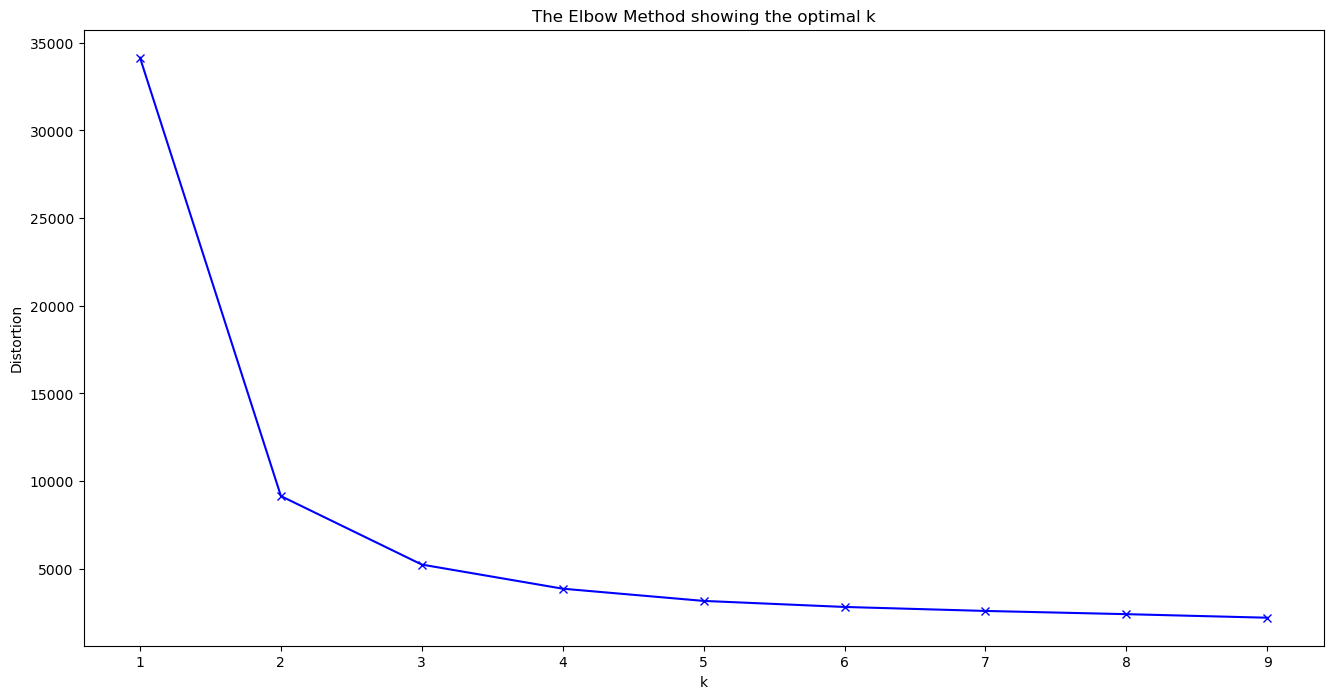

In [6]:
# K-Means Customer Segment Variable with REVENUE

# Instantiate scaler
scaler = StandardScaler()

# Subset for explanatory variables for customer segmentation EXCLUDING REVENUE
X = churn.loc[:, churn.columns[
    churn.columns.isin(['log_EstimatedSalary',
                         'log_CreditScore',
                         'log_Charge',
                         'log_TotalCharges',
                         'year_tenure'])]].values

# Fit the scaler with our data for customer segmentation
scaler.fit(X)

# Fit the scaler with our data for customer segmentation
X_scaled = scaler.transform(X)




##############################################################################
# Plot elbow point for optimal K

# Placeholder
distortions = []

# Number of Ks
K = range(1,10)

# Loop through each K
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)                            # Fit with X
    distortions.append(kmeanModel.inertia_)      # Append inertia to distortions
    
# "Inertia can be recognized as a measure of how internally coherent clusters are."
# https://scikit-learn.org/stable/modules/clustering.html

# Plot elbow point
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Source:
# https://predictivehacks.com/k-means-elbow-method-code-for-python/

<br><br><br>

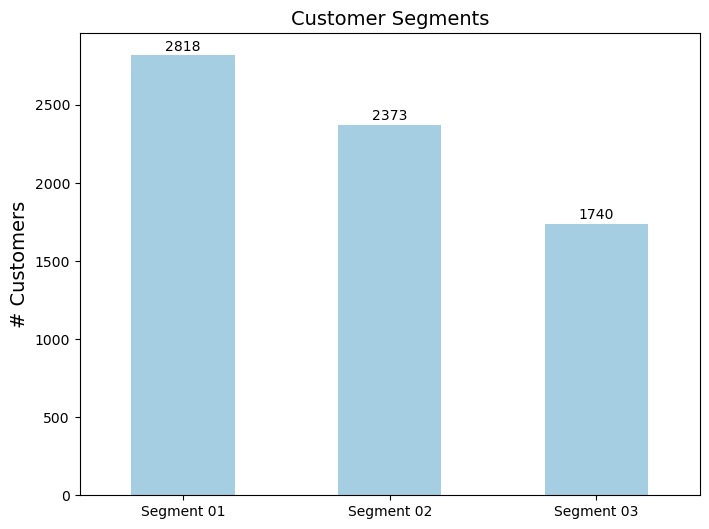

In [7]:
# Instantiate number of clusters
clusterNum = 3

# Instantiate KMEANS model
k_means = KMeans(init         = "k-means++", 
                 n_clusters   = clusterNum, 
                 n_init       = 12,
                 random_state = 219)

# Fit the model
k_means.fit(X_scaled)

# Grab each label (segmentation) for each customer
k_means_labels = k_means.labels_

# Add cluster labels to data set
churn["KMEANS_CLUSTERS"] = k_means_labels

# Display cluster average per variable
#churn.groupby('KMEANS_CLUSTERS').mean()

##############################################################################
# Plot 

# Count number of churn per month
clusters = churn['KMEANS_CLUSTERS'].value_counts()

# Create plot
ax = clusters.plot(kind='bar', 
                  legend = True,
                  figsize = (8,6),
                  rot = 0,
                  colormap = "Paired")


# Annotate plot with values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 6),
                textcoords='offset points')

# Set plot aesthetics
ax.set_ylabel('# Customers',size = 14)
ax.set_xlabel('')
ax.set_title("Customer Segments", size = 14)
ax.set_xticklabels(labels = ['Segment 01', "Segment 02", "Segment 03"])
ax.legend().remove()
 
# Display plot
plt.show()
#plt.close()


##############################################################################
# Convert KMEANS_CLUSTERS into Dummy Variables

# Get dummy variables for KMEANS_CLUSTERS
one_hot_Clusters = pd.get_dummies(churn['KMEANS_CLUSTERS'])

# Rename columns
one_hot_Clusters.columns = ['KMEANS_CLUSTER_0', 'KMEANS_CLUSTER_1', 'KMEANS_CLUSTER_2']

# Drop cluster 0 to follow n-1 
one_hot_Clusters.drop('KMEANS_CLUSTER_0', axis = 1, inplace = True)


# Drop KMEANS_CLUSTER 
churn = churn.drop('KMEANS_CLUSTERS', axis = 1)

# Join dummy variables back to churn dataframe
churn = churn.join([one_hot_Clusters])

<br><br><br><br><br><br><br><br><br>

## 4. Response Variable

<br><br><br>

In [8]:
churn.Churn.value_counts()

0    5105
1    1826
Name: Churn, dtype: int64

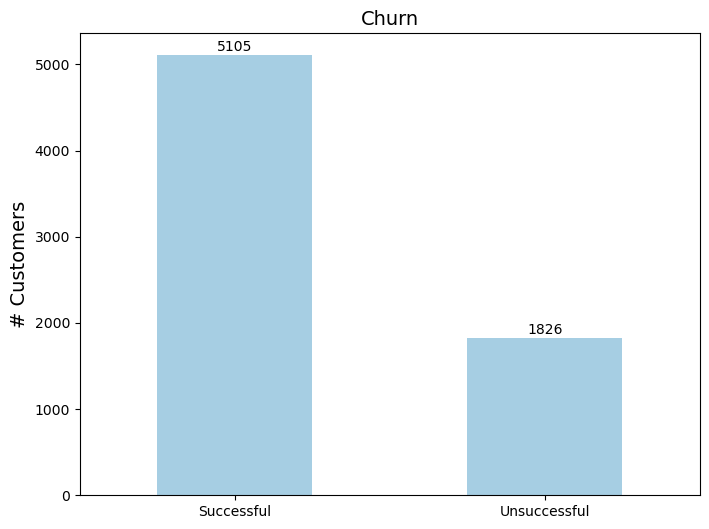


Proportions:
0    0.74
1    0.26
Name: Churn, dtype: float64


In [9]:
# CHURN_SUCCESS Proportions
churn_success = churn['Churn'].value_counts()

# Create plot
ax = churn_success.plot(kind='bar', 
                  legend = True,
                  figsize = (8,6),
                  rot = 0,
                  colormap = "Paired")


# Annotate plot with values
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 6),
                textcoords='offset points')

# Set plot aesthetics
ax.set_ylabel('# Customers',size = 14)
ax.set_xlabel('')
ax.set_title("Churn", size = 14)
ax.set_xticklabels(labels = ['Successful', "Unsuccessful"])
ax.legend().remove()
 
# Display plot
plt.show()
#plt.close()

print(f"""
Proportions:
{churn['Churn'].value_counts(normalize = True).round(decimals = 2)}""")

<br><br><br><br>

### 4.1 Correlations

<br><br><br>

In [10]:
# Churn Correlations

# Create correlation dataframe
df_corr = churn.corr(method = 'pearson')

# Display correlations with Churn_SUCCESS
y_corr = df_corr['Churn'].sort_values(ascending = False)

# Print variables correlated to Y
#y_corr.index
y_corr

Churn                       1.000000
KMEANS_CLUSTER_2            0.353981
CreditScore_per_tenure      0.309487
InternetService_Cat         0.305908
Salary_per_tenure           0.268743
log_Charge                  0.202019
MonthlyCharges              0.185788
Charge                      0.185788
StreamingMovies_Cat         0.159283
StreamingTV_Cat             0.153453
SeniorCitizen               0.148308
TotalServices               0.139396
InternetScore               0.138944
DeviceProtection_Cat        0.083821
OnlineBackup_Cat            0.073448
Salary_over_pmt_met         0.033457
EstimatedSalary             0.032941
log_EstimatedSalary         0.032855
MultipleLines_Cat           0.032235
Salary_per_CreditScore      0.026196
OnlineSecurity_Cat          0.019982
TechSupport_Cat             0.019655
log_CreditScore             0.016428
CreditScore                 0.015132
PhoneService_Cat            0.013021
Unnamed: 0                 -0.004941
Geography_Cat              -0.011222
S

<br><br><br><br><br><br><br><br><br>

## 5. Feature Selection

<br><br><br>

In [11]:
# Create feature groups dictionary

features_dict = {
  'logistic'         : [#'gender','SeniorCitizen','Partner','tenure',
                        #'PhoneService','MultipleLines','InternetService',
                        #'OnlineSecurity','OnlineBackup','DeviceProtection',
                        #'TechSupport','StreamingTV','StreamingMovies',
                        #'Contract','PaperlessBilling','Geography','Surname',
                        #'customerID','Dependents','PaymentMethod','Charge',
                        'TotalCharges',
                        'CreditScore',
                        'EstimatedSalary',
                        'MonthlyCharges',
                        'year_tenure',
                        'PhoneService_Cat',
                        'MultipleLines_Cat',
                        'InternetService_Cat',
                        'Contract_Cat',
                        'PaymentMethod_Cat',
                        'OnlineSecurity_Cat',
                        'OnlineBackup_Cat',
                        'DeviceProtection_Cat',
                        'TechSupport_Cat',
                        'StreamingTV_Cat',
                        'StreamingMovies_Cat',
                        'Partner_Cat',
                        'Dependents_Cat',
                        'AutomaticPayment',
                        'log_EstimatedSalary',
                        'log_CreditScore',
                        'log_Charge',
                        'log_TotalCharges',
                        'TotalServices',
                        'InternetScore',
                        'Partner_Dependents',
                        'CreditScore_per_tenure',
                        'Salary_per_tenure',
                        'Salary_per_CreditScore',
                        'Salary_per_TotalServices',
                        'Salary_over_pmt_met',
                        'Salary_Automatic',
                        'Geography_Cat'], 

  'tree'             : [

                        #'gender','SeniorCitizen','Partner','tenure',
                        #'PhoneService','MultipleLines','InternetService',
                        #'OnlineSecurity','OnlineBackup','DeviceProtection',
                        #'TechSupport','StreamingTV','StreamingMovies',
                        #'Contract','PaperlessBilling','Geography','Surname',
                        #'customerID','Dependents','PaymentMethod','Charge',
                        'TotalCharges',
                        'CreditScore',
                        'EstimatedSalary',
                        'MonthlyCharges',
                        'year_tenure',
                        'PhoneService_Cat',
                        'MultipleLines_Cat',
                        'InternetService_Cat',
                        'Contract_Cat',
                        'PaymentMethod_Cat',
                        'OnlineSecurity_Cat',
                        'OnlineBackup_Cat',
                        'DeviceProtection_Cat',
                        'TechSupport_Cat',
                        'StreamingTV_Cat',
                        'StreamingMovies_Cat',
                        'Partner_Cat',
                        'Dependents_Cat',
                        'AutomaticPayment',
                        'log_EstimatedSalary',
                        'log_CreditScore',
                        'log_Charge',
                        'log_TotalCharges',
                        'TotalServices',
                        'InternetScore',
                        'Partner_Dependents',
                        'CreditScore_per_tenure',
                        'Salary_per_tenure',
                        'Salary_per_CreditScore',
                        'Salary_per_TotalServices',
                        'Salary_over_pmt_met',
                        'Salary_Automatic',
                        'Geography_Cat' 
 ],           
 'tree_sig'          : [
                        'CreditScore',
                        'MonthlyCharges',
                        'year_tenure',
                        'InternetService_Cat',
                        'Contract_Cat',
                        'OnlineSecurity_Cat',
                        'OnlineBackup_Cat',
                        'log_TotalCharges',
                        'InternetScore',
                        'CreditScore_per_tenure'
 ],
 'forest'            :[
                        'TotalCharges',
                        'CreditScore',
                        'EstimatedSalary',
                        'MonthlyCharges',
                        'year_tenure',
                        'PhoneService_Cat',
                        'MultipleLines_Cat',
                        'InternetService_Cat',
                        'Contract_Cat',
                        'PaymentMethod_Cat',
                        'OnlineSecurity_Cat',
                        'OnlineBackup_Cat',
                        'DeviceProtection_Cat',
                        'TechSupport_Cat',
                        'StreamingTV_Cat',
                        'StreamingMovies_Cat',
                        'Partner_Cat',
                        'Dependents_Cat',
                        'AutomaticPayment',
                        'log_EstimatedSalary',
                        'log_CreditScore',
                        'log_Charge',
                        'log_TotalCharges',
                        'TotalServices',
                        'InternetScore',
                        'Partner_Dependents',
                        'CreditScore_per_tenure',
                        'Salary_per_tenure',
                        'Salary_per_CreditScore',
                        'Salary_per_TotalServices',
                        'Salary_over_pmt_met',
                        'Salary_Automatic',
                        'Geography_Cat'], 
    
 'rf_tuned'          : [
                        'TotalCharges',
                        'MonthlyCharges',
                        'year_tenure',
                        'InternetService_Cat',
                        'Contract_Cat',
                        'PaymentMethod_Cat',
                        #'OnlineSecurity_Cat',
                        #'TechSupport_Cat',
                        #'log_Charge',
                        #'log_TotalCharges',
                        'TotalServices',
                        'InternetScore',
                        'CreditScore_per_tenure',
                        'Salary_per_tenure'
 ]
}

<br><br><br>


## 6. Model Testing

<br><br><br>

### 6.1 Logistic Model


<br><br>



Lenght of oversampled data is 7146

Response Variable     Number    Proportion
-----------------     -------   -------------
Churn            3573        0.5
No Churn         3573        0.5


=================== MODEL SUMMARY ===================

Model Type: Logistic Regression

Model Size: 34

---------------------------------

LR Training Score : 0.7333
LR Testing Score  : 0.7462
LR Train-Test Gap : 0.0129

LR AUC Score      : 0.7351

---------------------------------

Coefficients:

                           Coefficient
MonthlyCharges            3.571554e-02
TotalServices             2.284477e-03
InternetScore             1.671226e-03
InternetService_Cat       7.545848e-04
Salary_per_CreditScore    4.007100e-04
log_Charge                2.528482e-04
CreditScore_per_tenure    2.166673e-04
StreamingMovies_Cat       1.876283e-04
StreamingTV_Cat           1.495552e-04
MultipleLines_Cat         8.722060e-05
EstimatedSalary           2.006839e-05
log_TotalCharges          1.657824e-05

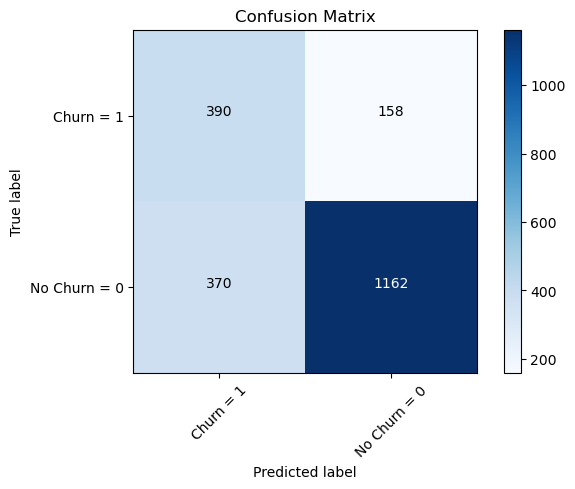

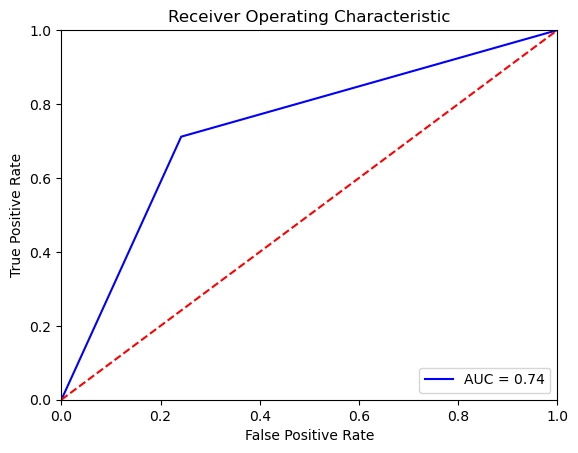

In [12]:
# Base Logistic Model (Variables = LOGISTIC)

# Specify explanatory variables
X = churn.loc[:, features_dict['logistic']]

# Specify response variable
y = churn.loc[:, 'Churn']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            test_size    = 0.3,
            random_state = 219,
            stratify     = y)


# Oversample
######################################
os = SMOTE(random_state=0)

os_data_x,os_data_y = os.fit_resample(X_train, y_train)
os_data_x = pd.DataFrame(data = os_data_x,
                         columns = features_dict['logistic'] )
os_data_y= pd.Series(data=os_data_y)

n_churn = len(os_data_y[os_data_y==0])
n_no_churn = len(os_data_y[os_data_y==0])
p_churn = len(os_data_y[
    os_data_y==0])/len(os_data_x)
p_no_churn = len(os_data_y[
    os_data_y==1])/len(os_data_x)


print(f"""

Lenght of oversampled data is {len(os_data_x)}

Response Variable     Number    Proportion
-----------------     -------   -------------
Churn            {n_churn}        {p_churn}
No Churn         {n_no_churn}        {p_no_churn}
""")


# Instantiate a logistic regression model
LR = LogisticRegression(solver       = 'lbfgs',
                        C            = 1,
                        random_state = 219,
                        max_iter     = 10000)


# Fit the logistic model
LR = LR.fit(os_data_x, os_data_y)

# Predict on test set
LR_pred = LR.predict(X_test)


# Create a dataframe of variable coefficients
lr_coeff = pd.DataFrame(LR.coef_[0], X.columns, columns=['Coefficient'])

# Filter out coefficients that equal 0 and sort by descending
lr_coeff = lr_coeff[lr_coeff['Coefficient'] != 0]\
                    .sort_values('Coefficient', ascending = False)

# Instantiate scores
LR_train_score = LR.score(os_data_x, os_data_y).round(4)
LR_test_score  = LR.score(X_test, y_test).round(4)
LR_test_gap    = abs(LR_test_score - LR_train_score).round(4)
LR_auc_score   = roc_auc_score(y_true  = y_test, y_score = LR_pred).round(4)
LR_report      = classification_report(y_test, 
                                       LR_pred,
                                       target_names = ['No Churn (0)',
                                                       'Churn (1)'])

# Score results
print(f"""
=================== MODEL SUMMARY ===================

Model Type: Logistic Regression

Model Size: {X.shape[1] + 1}

---------------------------------

LR Training Score : {LR_train_score}
LR Testing Score  : {LR_test_score}
LR Train-Test Gap : {LR_test_gap}

LR AUC Score      : {LR_auc_score}

---------------------------------

Coefficients:

{lr_coeff}
""")

print(classification_report(y_test, LR_pred))

##############################################################################
# Plot Confusion Matrix

# Unpack confusion matrix
LR_tn, \
LR_fp, \
LR_fn, \
LR_tp = confusion_matrix(y_true = y_test, y_pred = LR_pred).ravel()

LR_precission = LR_tp/(LR_tp+LR_fp)
LR_recall = LR_tp/(LR_tp+LR_fn)
LR_F1 = 2*(LR_precission*LR_recall)/(LR_precission+LR_recall)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, LR_pred, labels=[1,0])
np.set_printoptions(precision = 2)

# Assess performance by plotting non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes   = ['Churn = 1','No Churn = 0'],
                      normalize = False,  
                      title     = 'Confusion Matrix')
plt.show()

##############################################################################
# Plot ROC & AUC

# Calculate the FPR and TPR for all thresholds of the classification
probs = LR.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, LR_pred)
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Source of code:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>


<br><br><br>

### 6.2 Decision Tree


<br><br>



Lenght of oversampled data is 7658

Response Variable     Number    Proportion
-----------------     -------   -------------
Churn            3829        0.5
No Churn         3829        0.5


=================== MODEL SUMMARY ===================

Model Type: Decision Tree

Model Size: 11

---------------------------------

Decision Tree Training Score : 0.7608
Decision Tree Testing Score  : 0.7553
Decision Tree Test-Gap       : 0.0055
Decision Tree AUC Score      : 0.7559

---------------------------------


              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1276
           1       0.53      0.76      0.62       457

    accuracy                           0.76      1733
   macro avg       0.71      0.76      0.72      1733
weighted avg       0.80      0.76      0.77      1733



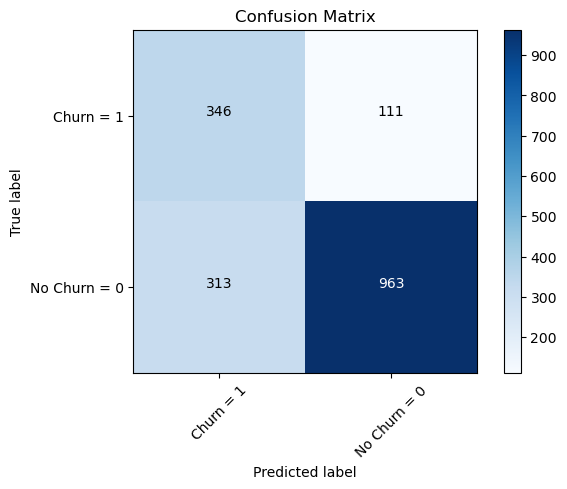

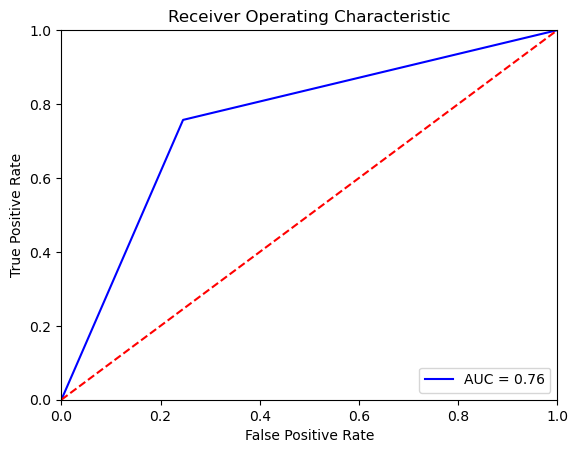

In [13]:
# Base Tree Model (Variables = TREE_SIG)

# Specify explanatory variables
X = churn.loc[:, features_dict['tree_sig']]

# Save column names
column_names = X.columns

# Instantiate scaler
scaler = RobustScaler()

# Fit scaler
scaler.fit(X)

# Transform explanatory variables
X_scaled = scaler.transform(X)
    
    
# Specify response variable
y = churn.loc[:, 'Churn']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
            X_scaled,
            y,
            test_size    = 0.25,
            random_state = 219,
            stratify     = y)  

# Oversample
######################################
os = SMOTE(random_state=0)

os_data_x,os_data_y = os.fit_resample(X_train, y_train)
os_data_x = pd.DataFrame(data = os_data_x,
                         columns = features_dict['tree_sig'] )
os_data_y= pd.Series(data=os_data_y)

n_churn = len(os_data_y[os_data_y==0])
n_no_churn = len(os_data_y[os_data_y==0])
p_churn = len(os_data_y[
    os_data_y==0])/len(os_data_x)
p_no_churn = len(os_data_y[
    os_data_y==1])/len(os_data_x)


print(f"""

Lenght of oversampled data is {len(os_data_x)}

Response Variable     Number    Proportion
-----------------     -------   -------------
Churn            {n_churn}        {p_churn}
No Churn         {n_no_churn}        {p_no_churn}
""")


# Instantiate a classification tree object
baseTree = DecisionTreeClassifier(criterion = 'gini',
                                  splitter  = 'best',
                                  max_depth = 4,
                                  min_samples_leaf = 25,
                                  random_state = 219)

# Fit the training data
baseTree = baseTree.fit(os_data_x.values, os_data_y)


# Predict churn
baseTree_pred = baseTree.predict(X_test)


# Reassign column names
os_data_x = pd.DataFrame(os_data_x, columns = column_names)


#####################
# Save scores
baseTree_train_score = baseTree.score(os_data_x.values, os_data_y).round(4) # accuracy
baseTree_test_score  = baseTree.score(X_test, y_test).round(4)   # accuracy
baseTree_test_gap    = abs(baseTree_test_score - baseTree_train_score).round(4)
baseTree_auc_score   = roc_auc_score(y_true  = y_test,
                                      y_score = baseTree_pred).round(4) # auc
baseTree_report      = classification_report(y_test, 
                                             baseTree_pred,
                                             target_names = [
                                                 'No Churn (0)',
                                                       'Churn (1)'])

#####################
# Score results
print(f"""
=================== MODEL SUMMARY ===================

Model Type: Decision Tree

Model Size: {X.shape[1] + 1}

---------------------------------

Decision Tree Training Score : {baseTree_train_score}
Decision Tree Testing Score  : {baseTree_test_score}
Decision Tree Test-Gap       : {baseTree_test_gap}
Decision Tree AUC Score      : {baseTree_auc_score}

---------------------------------

""")

print(classification_report(y_test, baseTree_pred))

##############################################################################
# Plot Confusion Matrix

# Unpack confusion matrix
baseTree_tn, \
baseTree_fp, \
baseTree_fn, \
baseTree_tp = confusion_matrix(y_true = y_test, y_pred = baseTree_pred).ravel()

baseTree_precission = baseTree_tp/(baseTree_tp+baseTree_fp)
baseTree_recall = baseTree_tp/(baseTree_tp+baseTree_fn)
baseTree_F1 = 2*(baseTree_precission*baseTree_recall)/(baseTree_precission+baseTree_recall)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, baseTree_pred, labels=[1,0])
np.set_printoptions(precision = 2)

# Assess performance by plotting non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes   = ['Churn = 1','No Churn = 0'],
                      normalize = False,  
                      title     = 'Confusion Matrix')
plt.show()

##############################################################################
# Plot ROC & AUC

# Calculate the FPR and TPR for all thresholds of the classification
probs = baseTree.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, baseTree_pred)
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Source of code:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

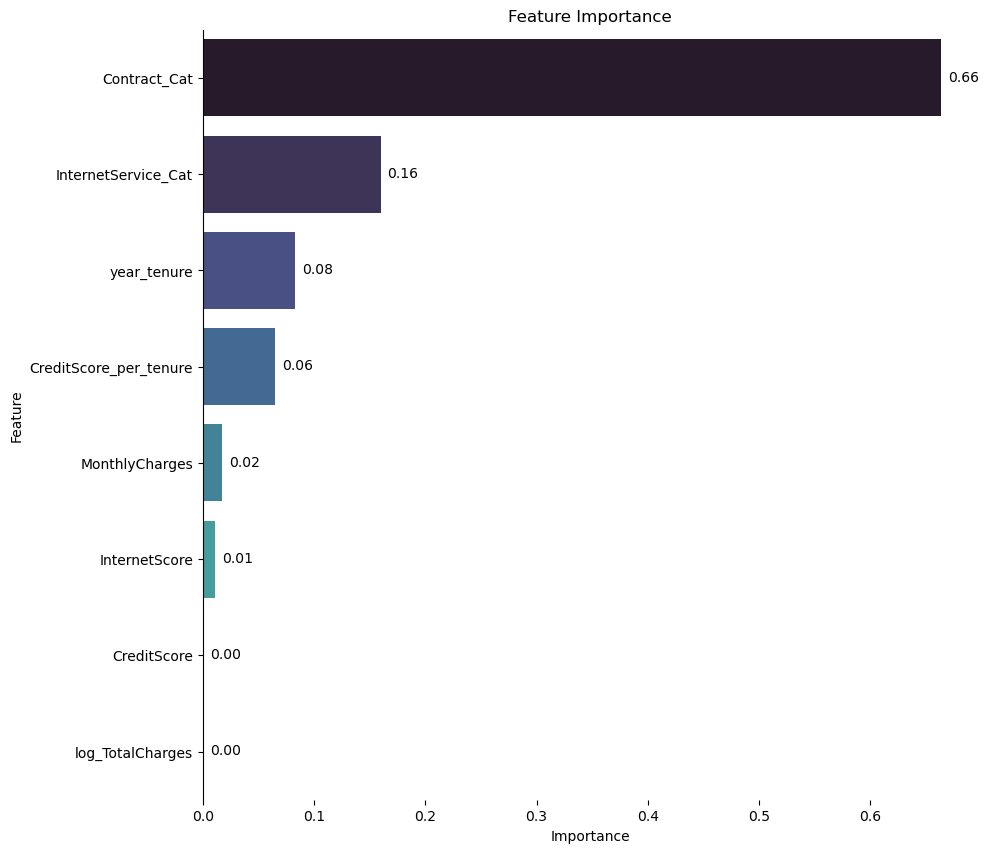

In [14]:
# Plot feature importance

# Create a dataframe of feature importance
feature_imp = pd.DataFrame(baseTree.feature_importances_, X.columns, columns=['Importance'])

# Filter out importance levels that equal 0 and sort by descending
feature_imp = feature_imp[feature_imp['Importance'] != 0]\
                            .sort_values('Importance', ascending = False)

# Plot

fig, ax = plt.subplots(figsize = (10, 10))

ax = sns.barplot(data    = feature_imp,
                 x       = 'Importance',
                 y       = feature_imp.index,
                 orient  = 'h',
                 palette = 'mako')

for p in ax.patches:    
    ax.annotate("%.2f" % p.get_width(), 
                   (p.get_x() + p.get_width(), 
                    p.get_y()), 
                    xytext=(5, -30), 
                    textcoords='offset points')


ax.set_yticks(np.arange(len(feature_imp)))
ax.set_yticklabels(feature_imp.index)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)


plt.show()

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

<br><br><br>

### 6.3 Random Forest


<br><br>



Lenght of oversampled data is 7658

Response Variable     Number    Proportion
-----------------     -------   -------------
Churn            3829        0.5
No Churn         3829        0.5


=================== MODEL SUMMARY ===================

Model Type: Random Forest

Model Size: 34

---------------------------------

RF Training Score : 0.88
RF Testing Score  : 0.794
RF Train-Test Gap : 0.086

RF AUC Score      : 0.7765

---------------------------------


              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1276
           1       0.59      0.74      0.65       457

    accuracy                           0.79      1733
   macro avg       0.74      0.78      0.75      1733
weighted avg       0.82      0.79      0.80      1733



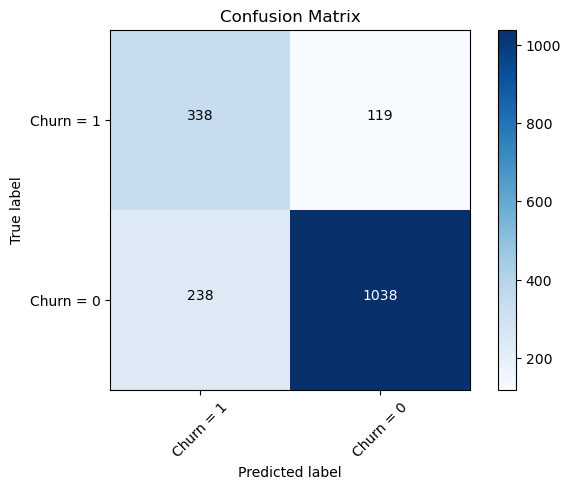

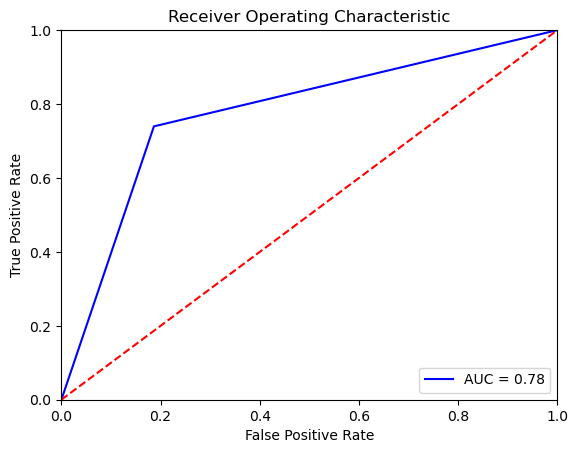

In [15]:
# Base Random Forest (Variables = FOREST)


##############################################################################
# Prepare data

# Specify explanatory variables
X = churn.loc[:, features_dict['forest']]

# Save column names
column_names = X.columns

# Instantiate scaler
scaler = RobustScaler()

# Fit scaler
scaler.fit(X)

# Transform explanatory variables
X_scaled = scaler.transform(X)


# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
            X_scaled,
            y,
            test_size    = 0.25,
            random_state = 219,
            stratify     = y) 

# Oversample
######################################
os = SMOTE(random_state=0)

os_data_x,os_data_y = os.fit_resample(X_train, y_train)
os_data_x = pd.DataFrame(data = os_data_x,
                         columns = features_dict['forest'] )
os_data_y= pd.Series(data=os_data_y)

n_churn = len(os_data_y[os_data_y==0])
n_no_churn = len(os_data_y[os_data_y==0])
p_churn = len(os_data_y[
    os_data_y==0])/len(os_data_x)
p_no_churn = len(os_data_y[
    os_data_y==1])/len(os_data_x)


print(f"""

Lenght of oversampled data is {len(os_data_x)}

Response Variable     Number    Proportion
-----------------     -------   -------------
Churn            {n_churn}        {p_churn}
No Churn         {n_no_churn}        {p_no_churn}
""")

# Reassign column names
os_data_x = pd.DataFrame(os_data_x.values, columns = column_names)

##############################################################################
# Create Model

# INSTANTIATING a random forest model with default values
rf_default = RandomForestClassifier(n_estimators     = 1000,
                                    criterion        = 'gini',
                                    max_depth        = 8,
                                    min_samples_leaf = 1,
                                    bootstrap        = True,
                                    warm_start       = False,
                                    random_state     = 219)

# FITTING the training data
rf_default = rf_default.fit(os_data_x.values, os_data_y)


# PREDICTING based on the testing set
rf_default_pred = rf_default.predict(X_test)


# Instantiate scores
rf_train_score = rf_default.score(os_data_x.values, os_data_y).round(4)
rf_test_score  = rf_default.score(X_test, y_test).round(4)
rf_test_gap    = abs(rf_test_score - rf_train_score).round(4)
rf_auc_score   = roc_auc_score(y_true  = y_test, y_score = rf_default_pred).round(4)
rf_report      = classification_report(y_test, 
                                       rf_default_pred,
                                       target_names = ['No Churn (0)',
                                                       'Churn (1)'])
# Print results
print(f"""
=================== MODEL SUMMARY ===================

Model Type: Random Forest

Model Size: {X.shape[1] + 1}

---------------------------------

RF Training Score : {rf_train_score}
RF Testing Score  : {rf_test_score}
RF Train-Test Gap : {rf_test_gap}

RF AUC Score      : {rf_auc_score}

---------------------------------

""")

print(classification_report(y_test, rf_default_pred))


##############################################################################
# Plot Confusion Matrix

# Unpack confusion matrix
rf_tn, \
rf_fp, \
rf_fn, \
rf_tp = confusion_matrix(y_true = y_test, y_pred = rf_default_pred).ravel()

rf_precission = rf_tp/(rf_tp+rf_fp)
rf_recall = rf_tp/(rf_tp+rf_fn)
rf_F1 = 2*(rf_precission*rf_recall)/(rf_precission+rf_recall)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, rf_default_pred, labels=[1,0])
np.set_printoptions(precision = 2)

# Assess performance by plotting non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes   = ['Churn = 1','Churn = 0'],
                      normalize = False,  
                      title     = 'Confusion Matrix')
plt.show()

##############################################################################
# Plot ROC & AUC

# Calculate the FPR and TPR for all thresholds of the classification
probs = rf_default.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, rf_default_pred)
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Source of code:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

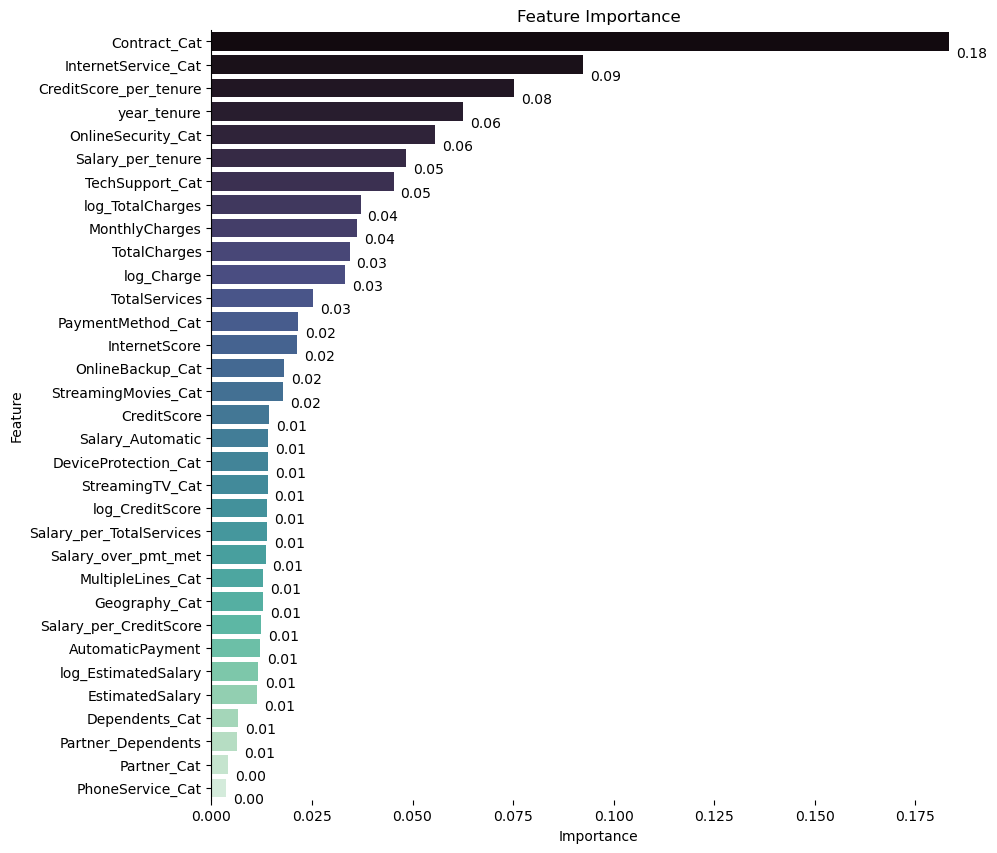

In [16]:
# Plot feature importance

# Create a dataframe of feature importance
feature_imp = pd.DataFrame(rf_default.feature_importances_, X.columns, columns=['Importance'])

# Filter out importance levels that equal 0 and sort by descending
feature_imp = feature_imp[feature_imp['Importance'] != 0]\
                            .sort_values('Importance', ascending = False)

# Plot

fig, ax = plt.subplots(figsize = (10, 10))

ax = sns.barplot(data    = feature_imp,
                 x       = 'Importance',
                 y       = feature_imp.index,
                 orient  = 'h',
                 palette = 'mako')

for p in ax.patches:    
    ax.annotate("%.2f" % p.get_width(), 
                   (p.get_x() + p.get_width(), 
                    p.get_y()), 
                    xytext=(5, -18), 
                    textcoords='offset points')


ax.set_yticks(np.arange(len(feature_imp)))
ax.set_yticklabels(feature_imp.index)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)


plt.show()

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

<br><br><br>

### 6.4 Tuned Random Forest


<br><br>



Lenght of oversampled data is 7658

Response Variable     Number    Proportion
-----------------     -------   -------------
Churn            3829        0.5
No Churn         3829        0.5


=================== MODEL SUMMARY ===================

Model Type: Random Forest Tuned

Model Size: 11

---------------------------------

Tuned Forest Training Score : 0.8039
Tuned Forest Testing Score  : 0.9123
Tuned Forest Train-Test Gap : 0.1084

Tuned Forest AUC Score      : 0.8597

---------------------------------


              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1276
           1       0.90      0.75      0.82       457

    accuracy                           0.91      1733
   macro avg       0.91      0.86      0.88      1733
weighted avg       0.91      0.91      0.91      1733



/Users/fernandacg/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:455: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


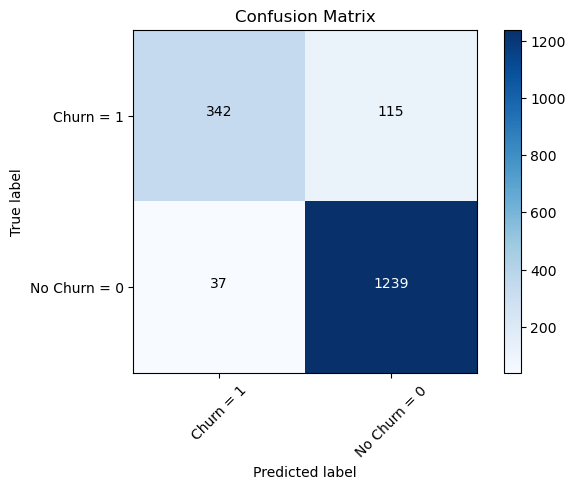

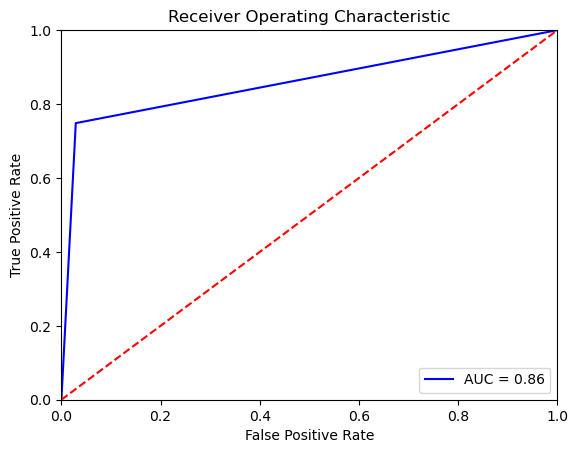

In [17]:
# Tuned Random Forest (Variables = GBM_SIG2)

##############################################################################
# Prepare data

# Specify explanatory variables
X = churn.loc[:, features_dict['rf_tuned']]

# Save column names
column_names = X.columns

# Instantiate scaler
scaler = RobustScaler()

# Fit scaler
scaler.fit(X.values)

# Transform explanatory variables
X_scaled = scaler.transform(X.values)


# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
            X.values,
            y,
            test_size    = 0.25,
            random_state = 219,
            stratify     = y)    


# Oversample
######################################
os = SMOTE(random_state=0)

os_data_x,os_data_y = os.fit_resample(X_train, y_train)
os_data_x = pd.DataFrame(data = os_data_x,
                         columns = features_dict['rf_tuned'] )
os_data_y= pd.Series(data=os_data_y)

n_churn = len(os_data_y[os_data_y==0])
n_no_churn = len(os_data_y[os_data_y==0])
p_churn = len(os_data_y[
    os_data_y==0])/len(os_data_x)
p_no_churn = len(os_data_y[
    os_data_y==1])/len(os_data_x)


print(f"""

Lenght of oversampled data is {len(os_data_x)}

Response Variable     Number    Proportion
-----------------     -------   -------------
Churn            {n_churn}        {p_churn}
No Churn         {n_no_churn}        {p_no_churn}
""")

##############################################################################
# Tune Hyperparameters

# declaring a hyperparameter space
estimator_space  = np.arange(140, 180, 10)
criterion_space  = ['gini', 'entropy']
depth_space      = np.arange(5, 12, 1)
#leaf_space       = np.arange(1, 10, 1)
bootstrap_space  = [True, True]
warm_start_space = [True, True]
#split_space      = np.arange(1, 525, 25)
#features_space   = np.arange(1, 14, 1)


# creating a hyperparameter grid
param_grid = {'n_estimators'     : estimator_space,
              'criterion'        : criterion_space,
              'max_depth'        : depth_space,
#              'min_samples_leaf' : leaf_space,
              'bootstrap'        : bootstrap_space,
              'warm_start'       : warm_start_space}


# INSTANTIATING the model object without hyperparameters
forest_grid = RandomForestClassifier(random_state = 219)


# GridSearchCV object
forest_cv = RandomizedSearchCV(estimator           = forest_grid,
                               param_distributions = param_grid,
                               cv           = 3,
                               n_iter       = 10,
                               random_state = 219,
                               scoring      = make_scorer(roc_auc_score,
                                              needs_threshold = False))


# FITTING to the FULL DATASET (due to cross-validation)
forest_cv.fit(X.values, y)


# PREDICT step is not needed


##############################################################################
# Create tuned model

# Instantiate model
rf_tuned = forest_cv.best_estimator_


# Fit the  model
rf_tuned = rf_tuned.fit(os_data_x.values, os_data_y)


# Predict on test set
rf_tuned_pred = rf_tuned.predict(X_test)


# Reassign column names
os_data_x = pd.DataFrame(os_data_x.values, columns = column_names)


# Instantiate scores
rf_tuned_train_score = rf_tuned.score(os_data_x.values, os_data_y).round(4)
rf_tuned_test_score  = rf_tuned.score(X_test, y_test).round(4)
rf_tuned_test_gap    = abs(rf_tuned_test_score - rf_tuned_train_score).round(4)
rf_tuned_auc_score   = roc_auc_score(y_true  = y_test, y_score = rf_tuned_pred).round(4)
rf_tuned_report      = classification_report(y_test, 
                                       rf_tuned_pred,
                                       target_names = ['No Churn (0)',
                                                       'Churn (1)'])
# Score results
print(f"""
=================== MODEL SUMMARY ===================

Model Type: Random Forest Tuned

Model Size: {X.shape[1] + 1}

---------------------------------

Tuned Forest Training Score : {rf_tuned_train_score}
Tuned Forest Testing Score  : {rf_tuned_test_score}
Tuned Forest Train-Test Gap : {rf_tuned_test_gap}

Tuned Forest AUC Score      : {rf_tuned_auc_score}

---------------------------------

""")

print(classification_report(y_test, rf_tuned_pred))


##############################################################################
# Plot Confusion Matrix

# Unpack confusion matrix
rf_tuned_tn, \
rf_tuned_fp, \
rf_tuned_fn, \
rf_tuned_tp = confusion_matrix(y_true = y_test, y_pred = rf_tuned_pred).ravel()

rf_tuned_precission = rf_tuned_tp/(rf_tuned_tp+rf_tuned_fp)
rf_tuned_recall = rf_tuned_tp/(rf_tuned_tp+rf_tuned_fn)
rf_tuned_F1 = 2*((rf_tuned_precission*rf_tuned_recall)/(rf_tuned_precission+rf_tuned_recall))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, rf_tuned_pred, labels=[1,0])
np.set_printoptions(precision = 2)

# Assess performance by plotting non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes   = ['Churn = 1','No Churn = 0'],
                      normalize = False,  
                      title     = 'Confusion Matrix')
plt.show()

##############################################################################
# Plot ROC & AUC

# Calculate the FPR and TPR for all thresholds of the classification
probs = rf_tuned.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, rf_tuned_pred)
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Source of code:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

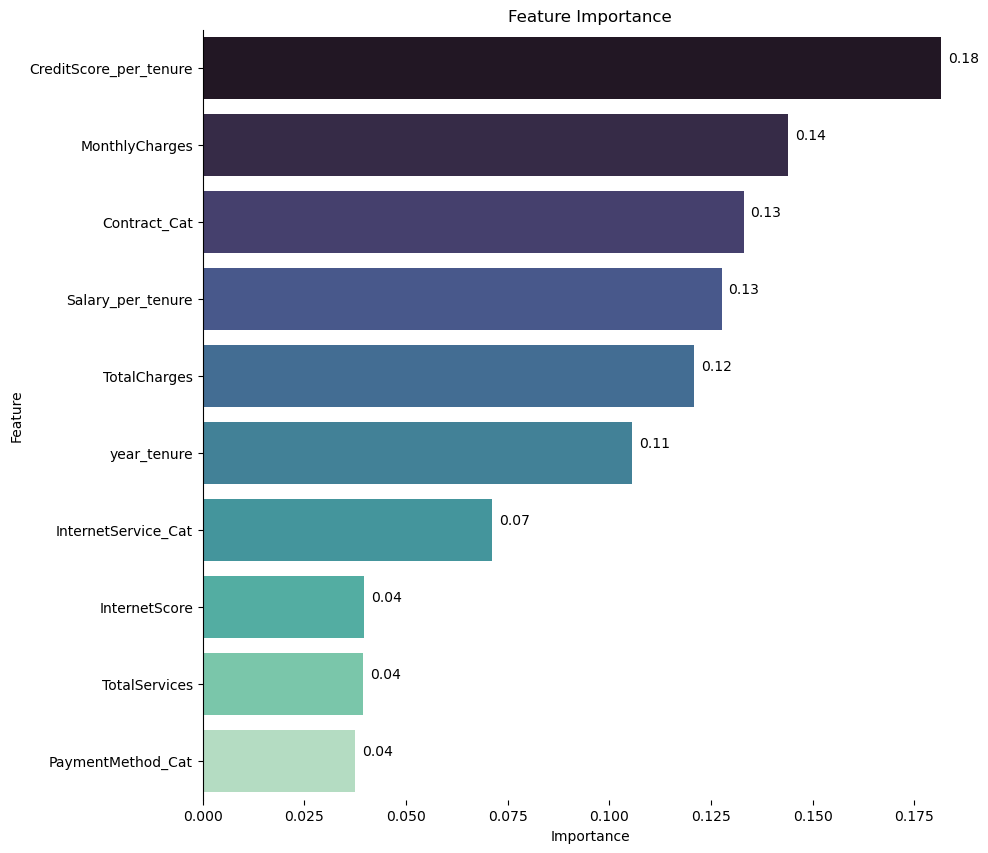

In [18]:
# Plot feature importance

# Create a dataframe of feature importance
feature_imp = pd.DataFrame(rf_tuned.feature_importances_, X.columns, columns=['Importance'])

# Filter out importance levels that equal 0 and sort by descending
feature_imp = feature_imp[feature_imp['Importance'] != 0]\
                            .sort_values('Importance', ascending = False)

# Plot

fig, ax = plt.subplots(figsize = (10, 10))

ax = sns.barplot(data    = feature_imp,
                 x       = 'Importance',
                 y       = feature_imp.index,
                 orient  = 'h',
                 palette = 'mako')

for p in ax.patches:    
    ax.annotate("%.2f" % p.get_width(), 
                   (p.get_x() + p.get_width(), 
                    p.get_y()), 
                    xytext=(5, -18), 
                    textcoords='offset points')


ax.set_yticks(np.arange(len(feature_imp)))
ax.set_yticklabels(feature_imp.index)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)


plt.show()

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

## 7. Model Comparison

<br><br><br>

In [19]:
# Print end result

# Time of script
t1 = time.time()

script_time = round((t1-t0)/60, 2)

# Compare results
print(f"""

======================================== Model Comparison ========================================



Model           Train Acc.   Test Acc. / F1      Gap         AUC Score           
-----           ----------   --------------     ------      ---------  
Logistic          {LR_train_score}         {LR_test_score}         {LR_test_gap}       {LR_auc_score}
Decision Tree     {baseTree_train_score}         {baseTree_test_score}         {baseTree_test_gap}       {baseTree_auc_score}      
Random Forest     {rf_train_score}           {rf_test_score}          {rf_test_gap}        {rf_auc_score}
Tuned RF          {rf_tuned_train_score}         {rf_tuned_test_score}         {rf_tuned_test_gap}       {rf_tuned_auc_score}      



     /-----------------------------------------------------------------------------------\\
     |        Tuned RF is the best model with an AUC of {rf_tuned_auc_score} and a F1 score of {rf_tuned_test_score}  |
     \\-----------------------------------------------------------------------------------/


""")




print(f"""

Total script run time: {script_time} minutes

""")



======================================== Model Comparison ========================================



Model           Train Acc.   Test Acc. / F1      Gap         AUC Score           
-----           ----------   --------------     ------      ---------  
Logistic          0.7333         0.7462         0.0129       0.7351
Decision Tree     0.7608         0.7553         0.0055       0.7559      
Random Forest     0.88           0.794          0.086        0.7765
Tuned RF          0.8039         0.9123         0.1084       0.8597      



     /-----------------------------------------------------------------------------------\
     |        Tuned RF is the best model with an AUC of 0.8597 and a F1 score of 0.9123  |
     \-----------------------------------------------------------------------------------/





Total script run time: 0.47 minutes




<br><br><br>

## 8. Business Recommendation

<br><br><br>

 
**Financially Stability and Tenure**

The amount of time customers are with the company and their individual credit score are the most important features, followed by tenure which is more relevant when analyzed by year instead of months, considering the contract options. For that reason, credit scores by tenure are the strongest predictor for churn rate. Similarly, the salary by tenure is also one of the most important ones and both have a positive correlation, meaning that new customers with high credit score or high salaries tend to have the highest churn rate. 

On another hand, the model tells us that having longer-term contracts will result in a lower churn rate, so the company should focus on providing longer term contracts with appealing prices instead of month - to - month plans.  

**Internet Score: How many services related to Internet do Customers have**

With multiple aspects of the internet services offered, it would be redundant to look at each one individually, therefore understanding the overall services used would be a more accurate value. Combining “internet services”, “online security”, “device protection”, “tech support”, “streaming tv” and “streaming movies” data to get the internet score, which while is not the most important feature, it does contribute to the overall accuracy of the model prediction and with a positive correlation with the churn rate. This means that the overall services offered does not bring satisfaction to the clients, or that this is not what they are looking for, and it's one of the factors that contributes for customers to discontinue their services with the organization. 

**Total Services and Internet Service**

Same analysis can be done with total services which also includes phone services and of they have multiple lines. Having more services does not help decrease the churn rate, in fact, this factor increase the churn rate. 

The total charges are a strong factor that decreases the churn rate since having a high total charges means the customer has been with the company for a long time. They are loyal customers who are not going to leave as easily. They are less likely to change as they are already immersed in the organization.


**FINAL RECOMMENDATION**

Using the *services* and the *monthly charges* analysis, a recommendation would be to focus on having a competitive price in each of the main services provided, rather than offering extra services and add-ons that would be charged as premium. This way, each customer would have a personalized plan with only high quality services that they actually use. Also, having low monthly payments by focusing on long-term contracts will attract customers that don't have a good financial stability, who, according to our model, are more likely to become loyal customers in the long run. Focusing on this market can help the company gain the attention of a part of the market that is most likely overseen by competition.

Using tuned random forest analysis, the model predicts the churn rate with 91% accuracy using, ordered by feature importance: the credit score per tenure, monthly charges, contract type, salary per tenure, total charges, tenure by year, internet services, internet score, total service and payment method. It’s important to take into consideration the limitations of this model as the internet services are included in 3 different variables and are affecting it more than once.


<br><br><br>

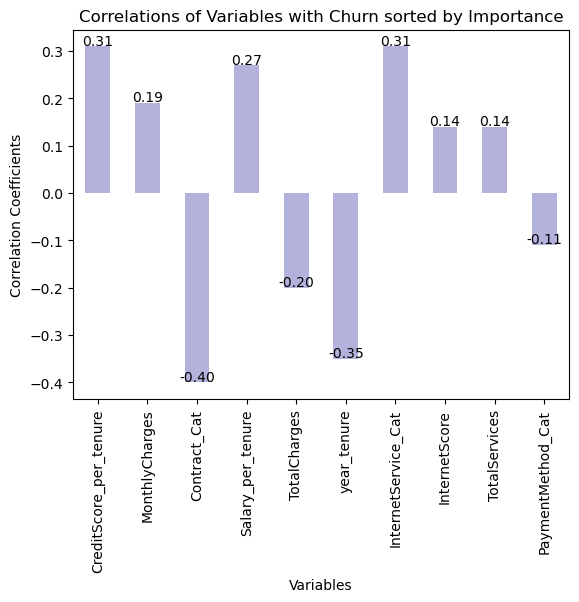

In [20]:
# Plot negative correlation coefficients of "Churn" with other variables:

# Create correlation dataframe and sort
corr = pd.DataFrame(churn.corr()['Churn'] \
                    .sort_values(ascending = False)\
                    .round(2))

# Filter for negative correlations
corr = corr.loc[['TotalCharges',
                        'MonthlyCharges',
                        'year_tenure',
                        'InternetService_Cat',
                        'Contract_Cat',
                        'PaymentMethod_Cat',
                        #'OnlineSecurity_Cat',
                        #'TechSupport_Cat',
                        #'log_Charge',
                        #'log_TotalCharges',
                        'TotalServices',
                        'InternetScore',
                        'CreditScore_per_tenure',
                        'Salary_per_tenure']]


corr_featureimp = pd.merge(corr, feature_imp,  
                   left_index=True, 
                   right_index=True, 
                   how = 'inner').sort_values(by = 'Importance', ascending = False)

corr_featureimp['Correlation'] = corr_featureimp['Churn']

corr_featureimp.drop(columns=['Churn'])


# Plot bar plot


ax = corr_featureimp.loc[:,'Correlation'].plot(kind = 'bar', color = 'darkblue', alpha = 0.3)

ax.set_title('Correlations of Variables with Churn sorted by Importance')
ax.set_xlabel('Variables')
ax.set_ylabel('Correlation Coefficients')


# Annotate plot with values
for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 4),
                textcoords='offset points')
    
plt.show()